# Wine Quality Prediction With Supervised Learning

https://github.com/addocolo/WineQuality/

## Introduction

In this study, we use a [dataset from the University of California, Irvine](https://archive.ics.uci.edu/dataset/186/wine+quality), containing chemical features of different types of Vinho Verde from the north of Portugal. It also includes a quality score between 0 and 10. The data is divided into two files: one for red wines and one for white wines. For this study, we combine the two and attempt to classify the "high" quality wines from the "low" quality wines.


The goal of this project is to categorize wines into either "high" or "low" quality categories based on their chemical features. We would like to discover which features are most associated with higher quality wines. We will use various supervised learning models to identify the best model for this task.

The main steps of our analysis include:

1.	Data Preparation: Cleaning and preprocessing the data to ensure its quality and consistency.

2.	Exploratory Data Analysis: Visualizing and understanding the distribution and relationships of the features.

3.	Baseline Modeling: Implementing and evaluating initial models using various supervised machine learning algorithms with default hyperparameters.

4.	Hyperparameter Tuning: Optimizing the models to improve their performance.

5.	Results: Comparing the different models used and analyzing the results of the best model found.



### Import modules and data

In [ ]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Import machine learning models
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

# Import metrics for model evaluation
from sklearn.metrics import f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score

# Import tools for model training and data preprocessing
from sklearn.model_selection import GridSearchCV, KFold, train_test_split
from sklearn.preprocessing import MinMaxScaler
from imblearn.under_sampling import RandomUnderSampler

# Let pandas display wider columns - necessary for model parameters later
pd.set_option('display.max_colwidth', 150)

## Data: Preparation and analysis

### Importing and initial cleaning of data

The initial step involved importing the data and checking for any duplicates or invalid entries. The dataset is composed of 4,898 white wines and 1,599 red wines. There are 11 chemical features and one target: quality. The chemical features all positive float type variables. The features are fixed acidity, volatile acidity, citric acid, residual sugar, chlorides, free sulfur dioxide, total sulfur dioxide, density, pH, sulphates, and alcohol.

Upon initial inspection, we noticed several duplicate entries in both the red and white wine datasets, which were subsequently removed.

Each dataset has identical columns, facilitating their merge into a single dataframe. Before merging, we added a categorical binary 'type' column, where 0 represents red wine and 1 represents white wine, enabling us to differentiate between the two types post-merging.

To classify wines into two quality groups, we binarized the quality score by setting a threshold of 7: wines with a score of 7 or higher were labeled as high quality (1), while those below 7 were labeled as low quality (0). This threshold was chosen to represent approximately 20% of the dataset, providing a reasonable proportion to be considered better than average. 

An inspection of the mean and maximum values of our features revealed some extreme outliers in the data. For example, mean sulfur dioxide has a mean value of about 30, but its highest value is 289. Additionally, the feature chlorides exhibits considerable positive skew. Preliminary correlation analysis indicates potential collinearity among certain features. These issues will be addressed in the Data Preprocessing section.

In [ ]:
# Import raw data for white and red wines
white_df = pd.read_csv('data/winequality-white.csv', sep=';')
red_df = pd.read_csv('data/winequality-red.csv', sep=';')

In [ ]:
# Display basic information about the datasets
print("White:")
print(f"\tShape: {white_df.shape}")
print(f"\tDupes: {white_df.duplicated().sum()}")
print(f"\tNaN: {white_df.isna().sum().sum()}")
print()
print("Red:")
print(f"\tShape: {red_df.shape}")
print(f"\tDupes: {red_df.duplicated().sum()}")
print(f"\tNaN: {red_df.isna().sum().sum()}")
print()
print(f"Columns match: {white_df.columns.equals(red_df.columns)}")
print()
print("Columns:")
print(f"{white_df.columns.to_series()}")


In [ ]:
# Display first few rows of each dataset
display(white_df.head())
display(red_df.head())

In [ ]:
# Add 'type' encoding to distinguish between red and white wines
red_df['type'] = 0
white_df['type'] = 1

# Drop duplicate rows from each dataset
red_df = red_df.drop_duplicates()
white_df = white_df.drop_duplicates()

# Merge the datasets into a single DataFrame
df = pd.concat([white_df, red_df], ignore_index=True)

# Binarize 'quality' column (1 = high quality, 0 = low quality) and move it to the last column
quality = df.pop('quality')
quality = (quality >= 7).astype(int)
df['quality'] = quality

# Store feature names for easy retrieval later
features = df.drop(columns=['quality']).columns

In [ ]:
# Display basic statistics, skewness, and correlation matrix
display(df.describe())
display(df.skew())
display(df.corr())

### Exploratory data analysis

For our EDA we will examine several visualizations of our data.

1. **Bar chart of wine qualities**: The bar chart illustrates the distribution of wine qualities across both red and white wines. Quality scores are 0 for low quality and 1 for high quality. The data is quite unbalanced with samples of low quality outnumbering high at about 4:1. This was by design since high quality wine implies some level of exclusivity. Conversely, there are relatively few quality scores of 3 and 9, which represent outliers of very low and very high quality, respectively. This imbalance persist across both red and white wines.

2. **Box Plot of Wine Feature Distributions**: The box plot illustrates the distributions of various chemical features in the wine dataset. Several features, such as residual sugar and total sulfur dioxide, display right-skewed distributions with numerous outliers, indicating significant variability. In contrast, features like pH and density exhibit more normal distributions with fewer extreme values, suggesting more consistency. These visual summaries help identify potential outliers and understand the spread and skew of each feature, guiding further analysis and potential data transformations.

3. **Feature Correlation Matrix**: The correlation matrix presents the relationships between various chemical properties and their impact on wine quality. Certain features like alcohol content have a moderate positive correlation with wine quality, suggesting that higher alcohol levels are associated with better quality wines. Conversely, features like volatile acidity show a negative correlation with quality, indicating that lower acidity is preferred. Perhaps unsurprisingly free sulfur dioxide and total sulfur dioxide are strongly correlated. Interestingly, it also identifies some features, such as volatiles acidity and total sulfur dioxide, that are correlated with type, indicating how we might differentiate red from white by chemical features.

4. **Feature Pairwise Plot**: This plot helps visually expand on the correlation matrix. It provides a comprehensive view of the interaction between the features. 




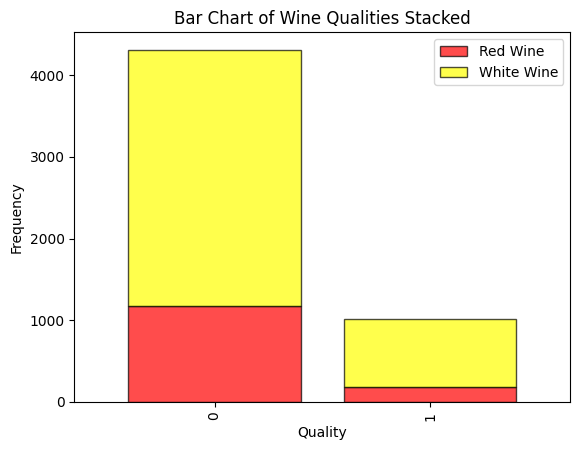

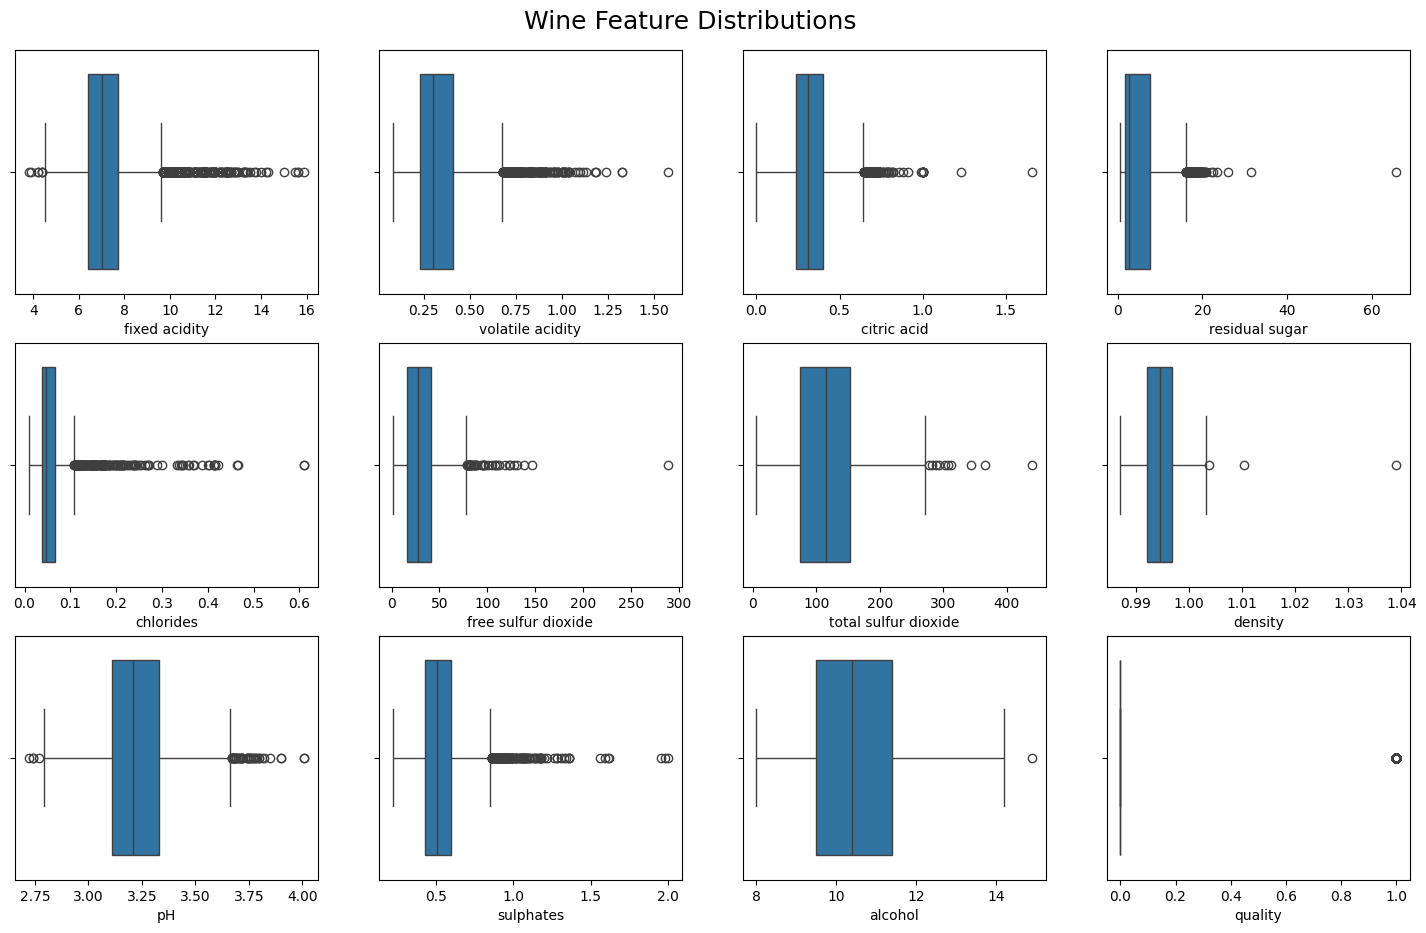

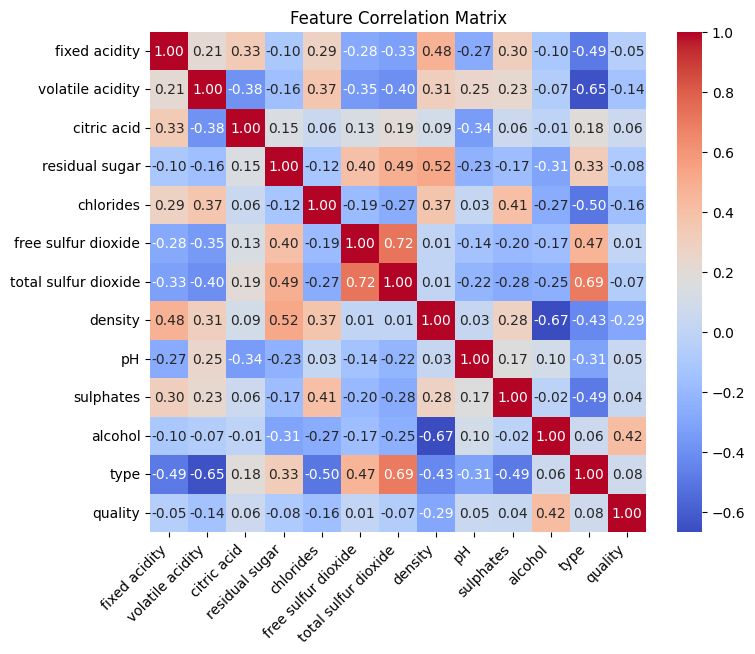

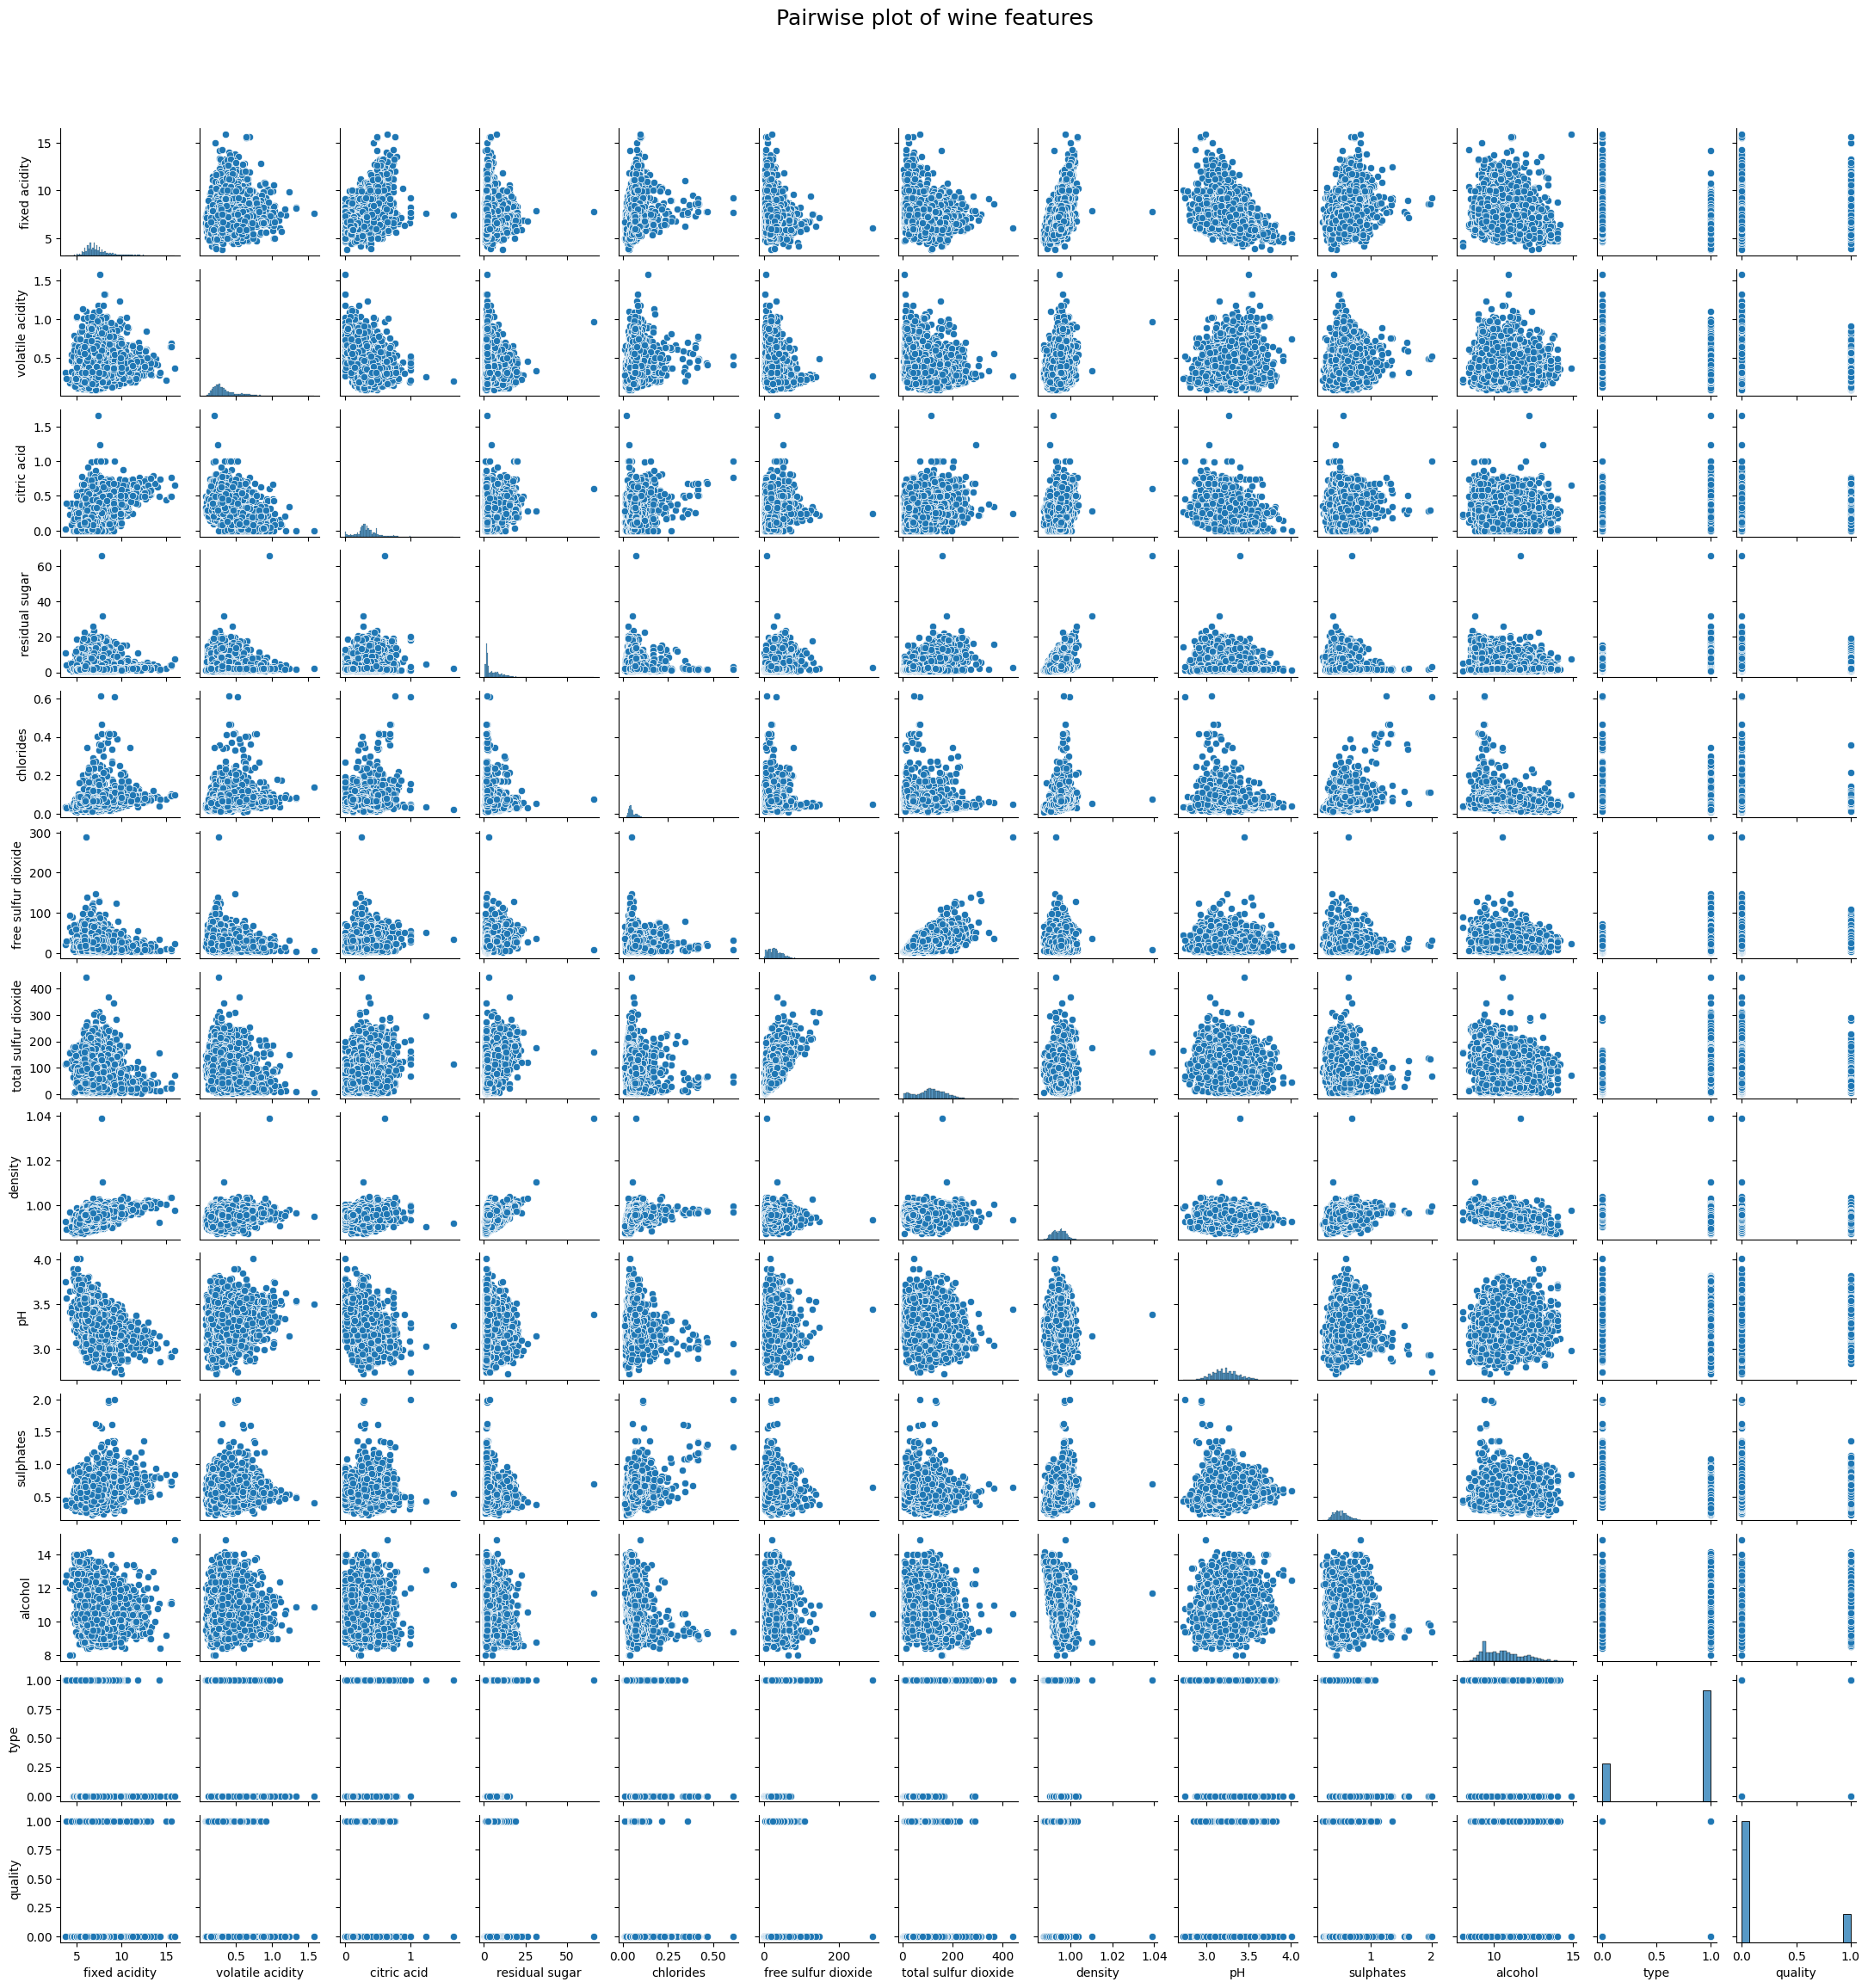

In [ ]:
# Plot a bar chart of wine qualities
pivot_df = df.pivot_table(index='quality', columns='type', aggfunc='size', fill_value=0)
pivot_df.plot(kind='bar', stacked=True, color=['red', 'yellow'], alpha=0.7, width=0.8, edgecolor='black')
plt.xlabel('Quality')
plt.ylabel('Frequency')
plt.legend(['Red Wine', 'White Wine'])
plt.title('Bar Chart of Wine Qualities')
plt.show()

# Plot box plots of the feature distributions
columns = df.drop(columns=['type']).columns
fig = plt.figure(figsize = (18, 10))
fig.suptitle('Wine Feature Distributions', fontsize=18)
plt.subplots_adjust(top=0.94)
for i, col in enumerate(columns):
    plt.subplot(3, 4, i+1)
    sns.boxplot(x = df[col])

# Plot a correlation matrix to examine general correlation of features
correlation_matrix = df.corr()
plt.figure(figsize=(8, 6.5))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Feature Correlation Matrix')
plt.xticks(rotation=45, ha='right')
plt.show()

# Plot pairwise plots of each feature
sns.pairplot(df, height=1.7);
plt.suptitle('Pairwise plot of wine features', y=1.05, fontsize=18);

### Further Cleaning and Preprocessing

From our correlation matrix we see that the 'free sulfur dioxide' and 'total sulfur dioxide' were quite strongly correlated (0.72) though not perfectly collinear. While this is a strong correlation, we believed that it was not strong enough to indicate collinearity. As such decided not to take measures to control their interaction. Doing so may slightly improve the Logistic Regression model, but we believe it could only work to the detriment of the other models since the random forest and gradient boosting models can handle multicollinearity better and benefit from having both features. Additionally, preserving both 'free sulfur dioxide' and 'total sulfur dioxide' allows us to retain more nuanced information in our dataset, which may be beneficial for interpreting the results.

From our Exploratory Data Analysis (EDA), it is clear that we have a potential issue with outliers in our data. As a result, we numerically identified features with positive skew and applied a log transformation to them. This transformation helps reduce the impact of skewness, bringing the data closer to a normal distribution. Stabilizing the variance in this manner should improve the performance, especially for models like Logistic Regression and K-Nearest Neighbors, which are more susceptible to skewed distributions.

To further address extreme outliers, we applied Winsorization by clipping the data at the 1st and 99th percentiles. This technique ensures that extreme outliers do not disproportionately influence the models, leading to more robust predictions.

We then applied a scaler to the numerical features of the dataset. This step is particularly beneficial for the K-Neighbors model, as it ensures that all features are on the same scale, preventing any single feature from dominating the distance metric used in the algorithm.

Given that our data is unbalanced with approximately a 4:1 ratio, we applied a random undersampling function to our training dataset. This approach helps ensure that the model is trained on balanced data, avoiding bias towards the larger category and improving overall model performance on minority class predictions.

Finally, we split our data into training (75%) and testing (25%) sets.

In [ ]:
# Create a copy of the DataFrame without the 'quality' column for scaling
df_scaled = df.drop(columns='quality').copy()


# Log transorm to reduce skew
skewed_features = df.skew()[df.skew() > 3].index
print(f"Positive skew detected in {', '.join(skewed_features)}.")
df[skewed_features] = np.log(df[skewed_features])

# Winsorization to remove extreme outliers
from scipy.stats import zscore
outlier_features = df.columns[(np.abs(zscore(df)) > 3).any(axis=0)]
outlier_features = [x for x in outlier_features if x not in ['type', 'quality']]
print(f"Features with extreme outliers (z-score > 3): {', '.join(outlier_features)}")
df[outlier_features] = np.clip(df[outlier_features], df[outlier_features].quantile(0.01), df[outlier_features].quantile(0.99), axis=0)

# Scale continuous/numerical features using MinMaxScaler
scaler = MinMaxScaler()
numerical_features = df.drop(columns=['type', 'quality']).columns
df_scaled[numerical_features] = scaler.fit_transform(df_scaled[numerical_features])

# Separate features and target variable
X = df_scaled[features]
y = df['quality']

# Use RandomUnderSampler to balance the dataset
undersampler = RandomUnderSampler(sampling_strategy='auto', random_state=42)
X_resampled, y_resampled = undersampler.fit_resample(X, y)

# Split the resampled data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.25, random_state=42)

Positive skew detected in chlorides.
Features with extreme outliers (z-score > 3): fixed acidity, volatile acidity, citric acid, residual sugar, chlorides, free sulfur dioxide, total sulfur dioxide, density, pH, sulphates, alcohol


## Baseline Model Analysis

To establish a performance benchmark, we trained four supervised classification models (Logistic Regression, Random Forest, K-Nearest Neighbors, and Gradient Boosting) using their default hyperparameters. Each model was fitted to the training data, and predictions were evaluated on both the training and test sets. We measured a number of performance metrics including accuracy, F1, and ROC-AUC to compare performance across models, identifying potential overfitting or underfitting. These baseline results serve as a reference point for further model tuning and optimization.

- **Logistic Regression**: A linear model that estimates probabilities using a logistic function. It is highly interpretabie and serves as a good baseline, but may encounter issues if relationships are not linear.
- **Random Forest Classifier**: An ensemble of decision trees that is resistant to overfitting. Random Forest is useful for handling non-linear relationships in the data and provides feature importance metrics, enhancing interpretability.
- **K-Nearest Neighbors (KNN)**: A distance-based model that classifies samples based on their nearest neighbors. It can be effective when the decision boundary is complex and non-linear.
- **Gradient Boosting Classifier**: A powerful ensemble method that sequentially corrects errors from previous models. It builds trees in a stage-wise manner, optimizing a loss function for each new tree.

Each model was chosen to offer a mix of linear, tree-based, and instance-based approaches, allowing us to compare different learning paradigms before refining the best-performing model.

All models had accuracy, F1, and ROC-AUC scores within the range of 0.75-0.80. Based on these baseline results, our initial test did not strongly favor any particular model over the others. Therefore, we proceeded to the refinement stage with all four models. Although K-Neighbors lagged slightly behind the other classifiers, the difference was not significant enough to eliminate it at this stage.

In [ ]:
# Define classifier models
clf_models = {
    'Logistic Regression': LogisticRegression(class_weight='balanced'),
    'Random Forest Classifier': RandomForestClassifier(class_weight='balanced', random_state=42),
    'KNN Classifier': KNeighborsClassifier(),
    'Gradient Boosting Classifier': GradientBoostingClassifier(random_state=42)
}

# Train and evaluate each model
for model_name, model in clf_models.items():
    model.fit(X_train, y_train)

    yp_train = model.predict(X_train)
    yp_test = model.predict(X_test)

    # Calculate scores in different metrics
    accuracy = accuracy_score(y_test, yp_test)
    precision = precision_score(y_test, yp_test)
    recall = recall_score(y_test, yp_test)
    f1 = f1_score(y_test, yp_test)
    roc_auc = roc_auc_score(y_test, yp_test)

    # Display scores
    print(f"{model_name}:")
    print(f"\tAccuracy:   {accuracy:.5f}")
    print(f"\tPrecision:  {precision:.5f}")
    print(f"\tRecall:     {recall:.5f}")    
    print(f"\tF1 score:   {f1:.5f}")
    print(f"\tROC-AUC:    {roc_auc:.5f}")
    print()

Logistic Regression:
	Accuracy:   0.78416
	Precision:  0.74721
	Recall:     0.83058
	F1 score:   0.78669
	ROC-AUC:    0.78601

Random Forest Classifier:
	Accuracy:   0.78218
	Precision:  0.73404
	Recall:     0.85537
	F1 score:   0.79008
	ROC-AUC:    0.78510

KNN Classifier:
	Accuracy:   0.75644
	Precision:  0.70588
	Recall:     0.84298
	F1 score:   0.76836
	ROC-AUC:    0.75989

Gradient Boosting Classifier:
	Accuracy:   0.76238
	Precision:  0.72263
	Recall:     0.81818
	F1 score:   0.76744
	ROC-AUC:    0.76460



## Hyperparameter tuning

To optimize model performance, we conducted a grid search with cross-validation to explore different hyperparameter settings for each classifier. The grid search allows us to test multiple combinations of hyperparameters for each classifier and identify the best-performing configuration. We use 3-fold cross-validation to reduce the chance of overfitting to the training data.

We chose hyperparameter values based on a reasonable range around the default value for each parameter.

- **Logistic Regression**: Logistic regression is sensitive to the regularization parameter C, so a broad range is tested. We focus on l2 penalty, because it is compatible with a number of different solvers.

- **Random Forest Classifier**: We tested a number of different parameters to balance depth and complexity.

- **K-Neighbors Classifier**: We tested broad range of neighbors because it is the most critical hyperparameter, in addition to different metrics for calculating distance.

- **Gradient Boosting Classifier**: We tested multiple values of number of estimators and learning rates to find a balance between overfitting and underfitting.

We chose the F1 score as the primary metric for evaluating model performance. The F1 score offers a balanced measure by considering both precision and recall, which is critical for accurately identifying high-quality wines while minimizing false positives.

Following this we inserted the results of all models tested of each type into a dataframe in order to compare the performance across the different types of models.

In [ ]:
# Define parameter grids for grid search
n_jobs = -1
kf = KFold(3, shuffle=True, random_state=42)

clf_grid = {
    'LogisticRegression': {
        'type': 'clf',
        'base_model': LogisticRegression(max_iter=1000),
        'param_grid': {
            'C': [0.1, 1, 5, 10, 20, 50, 100],
            'penalty': ['l2'],
            'solver': ['liblinear', 'saga', 'lbfgs']
        }
    },
    'RandomForestClassifier': {
        'type': 'clf',
        'base_model': RandomForestClassifier(random_state=42),
        'param_grid': {
            'n_estimators': range(50, 201, 50),
            'max_depth': range(5, 21, 5),
            'min_samples_split': range(2, 6),
            'min_samples_leaf': range(1, 4),
            'max_features': ['sqrt', 'log2', None]
        }
    },
    'KNeighborsClassifier': {
        'type': 'clf',
        'base_model': KNeighborsClassifier(),
        'param_grid': {
            'n_neighbors': range(3, 31),
            'weights': ['uniform', 'distance'],
            'metric': ['euclidean', 'manhattan']
        }
    },
    'GradientBoostingClassifier': {
        'type': 'clf',
        'base_model': GradientBoostingClassifier(random_state=42),
        'param_grid': {
            'n_estimators': range(50, 151, 50),
            'max_depth': range(3, 11),
            'learning_rate': [0.01, 0.05, 0.1, 0.2],
            'subsample': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
        }
    }
}

# Perform grid search for hyperparameter tuning, store in clf_grid
import time
for name, info in clf_grid.items():
    start = time.time()
    print(f"Running {name} grid search", end='')
    # Prepare grid search object
    grid = GridSearchCV(info['base_model'], param_grid=info['param_grid'], return_train_score=True, cv=kf, n_jobs=n_jobs, scoring='f1')
    grid.fit(X_train, y_train)      # Fit the grid on the training data
    info['grid'] = grid             # Store the grid search object in the dictionary
    print(f"... {time.time()-start:0.2f}s")

# Create a list to store the results of each grid search
classifier_info_list = list()

# Iterate model types and add their grid items to the dataframe
for model_name, model_data in clf_grid.items():
    print(model_name)
    grid = model_data['grid']
    
    results = grid.cv_results_  # Retrieve grid search results
    
    model_df = pd.DataFrame(results)  # Add results to new dataframe
    
    # Add data to new dataframe
    model_df['model'] = model_name   
    model_df['parameters'] = model_df.apply(lambda row: {param: row[f'param_{param}'] for param in model_data['param_grid'].keys()}, axis=1)    
    columns = ['model', 'mean_train_score', 'mean_test_score', 'std_test_score', 'mean_fit_time', 'std_fit_time', 'parameters']
    model_df = model_df[columns]
    
    # Append new dataframe to list of results
    classifier_info_list.append(model_df)

# Concatenate the individual DataFrames into a single DataFrame
classifier_df = pd.concat(classifier_info_list, ignore_index=True)
classifier_df = classifier_df.sort_values('mean_test_score', ascending=False) # higher is better

Running LogisticRegression grid search... 3.76s
Running RandomForestClassifier grid search... 82.19s
Running KNeighborsClassifier grid search

c:\Python\Python312\Lib\site-packages\numpy\ma\core.py:2892: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


... 2.47s
Running GradientBoostingClassifier grid search... 142.99s
LogisticRegression
RandomForestClassifier
KNeighborsClassifier
GradientBoostingClassifier


## Results

In this section, we present the results of our analysis and model evaluation. We begin by comparing the performance of various models to identify the top-performing ones. This comparison is followed by an analysis of the best model, including its performance metrics, confusion matrix, and feature importance.

1. **Model Performance Comparison**: We evaluated several supervised learning models to classify wines as "high" or "low" quality based on their chemical features. Our goal was to determine which model offers the best predictive performance.   

   - **Top Performing Model by Type**: To further explore model performance, we identified the top-performing model for each classifier type. The table below presents the best model of each type, along with their respective mean test accuracy scores and hyperparameters. The top perfoming model was a Gradient Boosting Classifier with parameters outlined in the chart below. This model performed adequately with a 3-fold mean F1 score of 0.772505. This suggests a good, but not ideal, balance between identifying both classes. The top Random Forest model was very competitive with our top model with an F1 score of 0.771026 as was K-Neighbors with an F1 score of 0.770214. The top Logistic Regression model was also competitive but a little behind the other methods.

   - **Box Plot of Mean Test Accuracy Scores**: We also visualized the distribution of mean test accuracy scores for all classifiers using a box plot. This helps to understand the variability in performance across different models and highlights the models that consistently achieve high accuracy. The plot reveals that across all tested parameters all four models have close mean F1 scores ranging from approximately 0.75 to 0.76. The Logistic Regression classifier was the most consistent performer and had the highest mean across all models, although it's best models didn't perform as well as some other methods. The Random Forest classifier was also relatively consistent and seemed to be immune to the lower end performance of some other models, perhaps because it does a good job of avoiding overfitting.

2. **Detailed Analysis of the Best Model**: After identifying the best-performing model overall, we conducted a detailed analysis to evaluate its performance on the test set.

   - **Best Model Evaluation**: The best model was selected based on its highest mean test F1 score during cross-validation. As above the model selected was a Gradient Boosting Classifier with parameters {'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 150, 'subsample': 0.9}. We evaluated its performance on the test set. The classification report and confusion matrix provide insights into the model's accuracy, precision, and recall scores.
      - Precision: For class 0, precision is 0.84, indicating a high rate of correctly identified low-quality wines among all predicted low-quality wines. For class 1, precision is 0.73, which is a respectable performance in identifying high-quality wines.
      - Recall: For class 0, recall is 0.71, meaning 71% of actual low-quality wines were correctly classified, which is also respectable if lower than we would have liked. For class 1, recall is a strong 0.85, meaning 85% of actual high-quality wines were correctly classified.
      - F1 Scores: The F1 scores of 0.77 (class 0) and 0.79 (class 1) reflect a balanced performance, meaning this model is similarly effective at handling both classes.
      - Accuracy: The model's accuracy score of 0.78 indicates a good but far from ideal performance for classifying high and low quality wines.

   - **Confusion Matrix Evaluation**
      - True Low (187): The model correctly identified 174 low-quality wines.
      - True High (206): The model correctly identified 209 high-quality wines.
      - False Low (36): 89 high-quality wines were incorrectly classified as low-quality.
      - False High (76): 33 low-quality wines were incorrectly classified as high-quality.

      The confusion matrix shows a respectable performance, with high numbers of true High and true Low classifications. While there are some misclassifications, the overall distribution suggests that the model is adept at distinguishing between high and low-quality wines, especially given the balanced nature of the F1 scores.

   - **Feature Importance**: Since the best model supports feature importance (eg. Gradient Boosting / Random Forest), we analyzed the importance of each feature. This analysis helps to understand which features contribute most to the model's predictions and can offer insights into the underlying factors influencing wine quality. There were some interesting findings:
      - By far the feature with the highest importance was alcohol (0.296), indicating that higher alchohol content is strongly associated with higher quality wines.
      - Volatile acidity and chlorides were second and third place respectively, although not nearly as important as alcohol.
      - The type, red or white, didn't seem to be of much importance at all (0.00077), suggesting that chemical features may vary in a similar way across classes regardless of the wine type.

### Comparing Models

Top Models of Each Type:


,model,mean_train_score,mean_test_score,std_test_score,mean_fit_time,std_fit_time,parameters
1139,GradientBoostingClassifier,1.000000,0.772505,0.023040,4.688877,0.322455,"{'n_estimators': 150, 'max_depth': 10, 'learning_rate': 0.1, 'subsample': 0.9}"
290,RandomForestClassifier,0.967027,0.771026,0.026550,0.928348,0.051971,"{'n_estimators': 100, 'max_depth': 10, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': None}"
652,KNeighborsClassifier,1.000000,0.770214,0.021866,0.005850,0.000570,"{'n_neighbors': 30, 'weights': 'distance', 'metric': 'euclidean'}"
10,LogisticRegression,0.769261,0.763906,0.030440,0.033379,0.002350,"{'C': 10.0, 'penalty': 'l2', 'solver': 'saga'}"


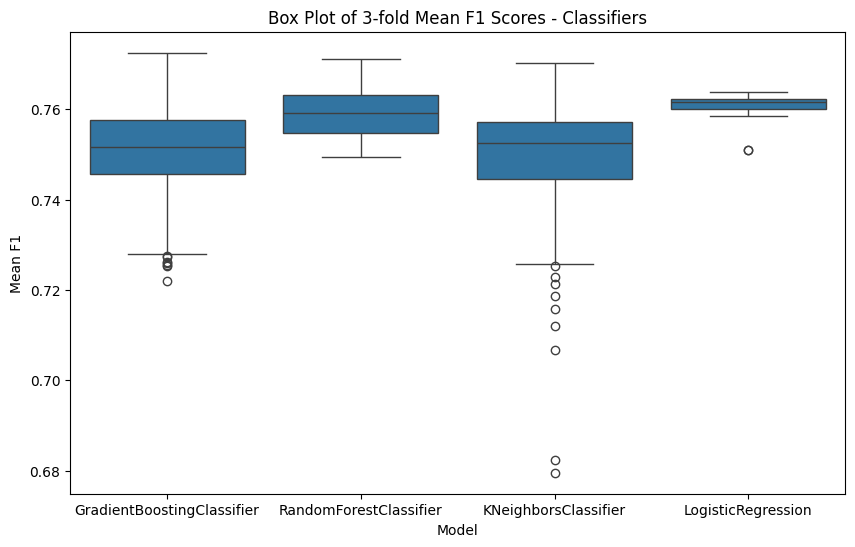

In [ ]:
# Display the top models by type
print("Top Models of Each Type:")
classifier_df = classifier_df.sort_values('mean_test_score', ascending=False)
display(classifier_df.loc[classifier_df.groupby('model')['mean_test_score'].idxmax()].sort_values('mean_test_score', ascending=False).head())

# Box plot of model performance by type
plt.figure(figsize=(10, 6))
sns.boxplot(x='model', y='mean_test_score', data=classifier_df)
plt.title(f'Box Plot of {kf.get_n_splits()}-fold Mean F1 Scores - Classifiers')
plt.xlabel('Model')
plt.ylabel('Mean F1')
plt.show()

### Top performing model

Best model: GradientBoostingClassifier
Best parameters: {'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 150, 'subsample': 0.9}
Train accuracy: 1.00000
Test accuracy: 0.77822
              precision    recall  f1-score   support

           0       0.84      0.71      0.77       263
           1       0.73      0.85      0.79       242

    accuracy                           0.78       505
   macro avg       0.78      0.78      0.78       505
weighted avg       0.79      0.78      0.78       505


alcohol: 0.29636728829372405
volatile acidity: 0.07960709671890284
chlorides: 0.07901359225104616
sulphates: 0.07740317765874909
residual sugar: 0.07442216671667992
total sulfur dioxide: 0.06918919283158281
density: 0.06869087215104076
free sulfur dioxide: 0.06758663853446566
pH: 0.0651305340422565
citric acid: 0.06473314100179528
fixed acidity: 0.057085474635812726
type: 0.0007708251639442393


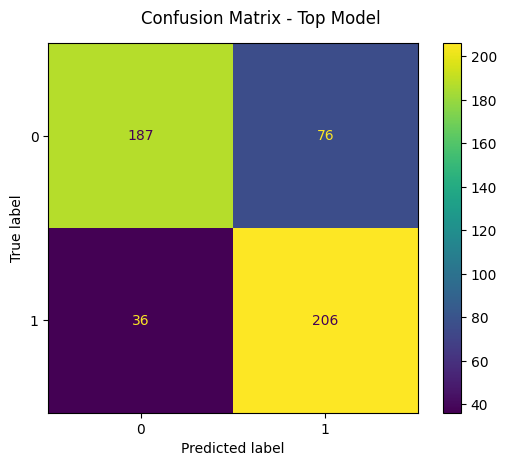

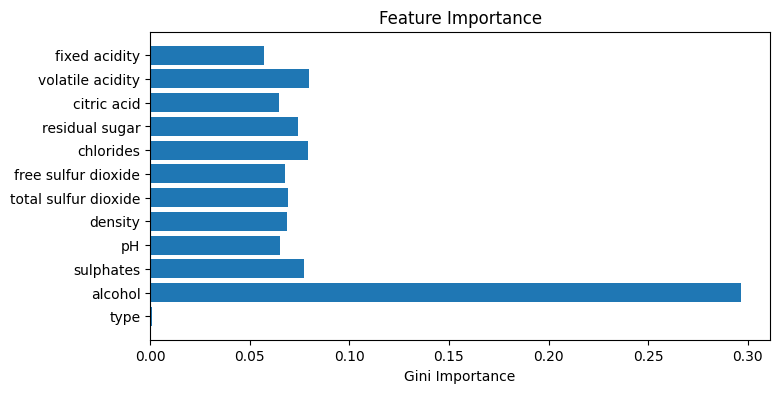

In [ ]:
# Train the top model with the best parameters
best_clf_name, best_clf_params = classifier_df.iloc[0][['model', 'parameters']]
model_clf = clf_grid[best_clf_name]['base_model']
model_clf.set_params(**best_clf_params).fit(X_train, y_train)

# Make predictions with the best model
yp_train = model_clf.predict(X_train)
yp_test = model_clf.predict(X_test)

# Report model performance on train and test sets
print(f"Best model: {type(model_clf).__name__}")
print(f"Best parameters: {clf_grid[best_clf_name]['grid'].best_params_}")
print(f"Train accuracy: {accuracy_score(y_train, yp_train):.5f}")
print(f"Test accuracy: {accuracy_score(y_test, yp_test):.5f}")
print(classification_report(y_test, yp_test))
print()

# Display test results in a confusion matrix
cm = confusion_matrix(y_test, yp_test)
cmd = ConfusionMatrixDisplay(cm).plot();
plt.suptitle("Confusion Matrix - Top Model", y=0.95)

# Bar plot of feature importance from the best model
importances = model_clf.feature_importances_
for f, imp in sorted(zip(features, model_clf.feature_importances_), key=lambda x: x[1], reverse=True):
    print(f"{f}: {imp:.5f}")  # Print features from most to least important
feature_imp_df = pd.DataFrame({'Feature': features, 'Importance': importances}).sort_values('Importance', ascending=False)
plt.figure(figsize=(8, 4))
plt.barh(features, importances)
plt.xlabel('Gini Importance')
plt.title('Feature Importance')
plt.gca().invert_yaxis()  # Invert y-axis for better visualization
plt.show()

## Conclusion

### Model Results

This study aimed to predict wine quality based on chemical features using various supervised learning models. While initial attempts to predict quality scores ranging from 0-10 yielded poor results, binarizing the quality scores provided a more manageable challenge.

Ultimately, the Gradient Boosting Classifier emerged as the top-performing model with a respectable F1 score of 0.78. However, when considering overall consistency and reliability, the Random Forest Classifier and Logistic Regression models also showed strong performance with more consistency. It's possible that over repeated random trials one or both of these models would emerge as winner. The Logistic Regression model could potentially be further improved by investigating feature interactions, which we did not explore in this study.

Interestingly, alcohol content was found to be the most significant predictor of wine quality, raising questions about whether higher alcohol content directly influences perceived quality or affects the ratings given by tasters. While this question lies outside the scope of our study, it provides an intriguing avenue for future exploration.

### Challenges with Data

Several challenges presented themselves during this study. Initially, we believed predicting wine quality would be straightforward, but it became clear that the task was more complex than anticipated.

One key challenge was the distribution of the quality scores, which led us to binarize the quality ratings to balance the classes better. Even then, creating this definition of "high" quality created an imbalance in the dataset. This issue was mitigated by undersampling our "low" quality data, but this may not be an ideal solution, as it results in a loss of information.

Additionally, dealing with outliers and skewed data was essential. Several chemical features had extreme outliers, which required careful preprocessing to avoid their disproportionate influence on the models. To address extreme outliers, we Winsorized our data. While this resulted in better predictions, it also led to a loss of information.

### Model Limitations
Despite our best efforts to overcome these challenges, the resulting models were only moderate predictors of wine quality. The chemical features used in this study may be inadequate for distinguishing between wines in the lower end of the high-quality category, possibly mixing wines that originally scored 6 or 7.

Moreover, it's possible that a more advanced model could uncover underlying relationships that our current models missed. The limitations of our approach highlight the need for further refinement and exploration.

### Future Study
To improve model performance, several potential avenues for future research could be explored. Analyzing interactions between features, particularly for Logistic Regression, might enhance model performance by providing deeper insights into feature relationships. Additionally, exploring more complex models, such as neural networks, could reveal nuanced patterns in the data that simpler models might miss. Using Principal Component Analysis (PCA) to reduce dimensionality could help capture the most relevant information while mitigating the impact of less informative features. Finally, including other relevant features not available in the current dataset might further improve predictions and refine the model's accuracy.

## References


Brownlee, Jason. (Mar. 17, 2021). SMOTE for Imbalanced Classification with Python. https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/

Cortez, P., Cerdeira, A., Almeida, F., Matos, T., & Reis, J. (2009). Wine Quality [Dataset]. UCI Machine Learning Repository. https://archive.ics.uci.edu/dataset/186/wine+quality.

Feature Importance with Random Forests. (05 Apr, 2024)
https://www.geeksforgeeks.org/feature-importance-with-random-forests/

Lundy, Daniel. (Jul 9, 2023). A Practical Guide to Wine Quality Prediction using Logistic Regression. https://medium.com/@daniel.lundy.analyst/a-practical-guide-to-wine-quality-prediction-using-logistic-regression-f390c5c4d71f.

Yagci, Hasan Ersan. (Jan 15, 2021). Detecting and Handling Outliers with Pandas. https://hersanyagci.medium.com/detecting-and-handling-outliers-with-pandas-7adbfcd5cad8